# Transfuse

> https://github.com/Rayicer/TransFuse

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=1c727987bf853958be27853c59121e3649580c3af6b4c35518259658dc13bc19
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=fece86aed13df9321a57574ed5be266223d8a69e73c9d658a154c5c7f6c4681c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing install

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
# !wandb login

## DataSet

### 数据集定义

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


## 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                      size=[192, 256])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 192, 256])
showing image of 444: 


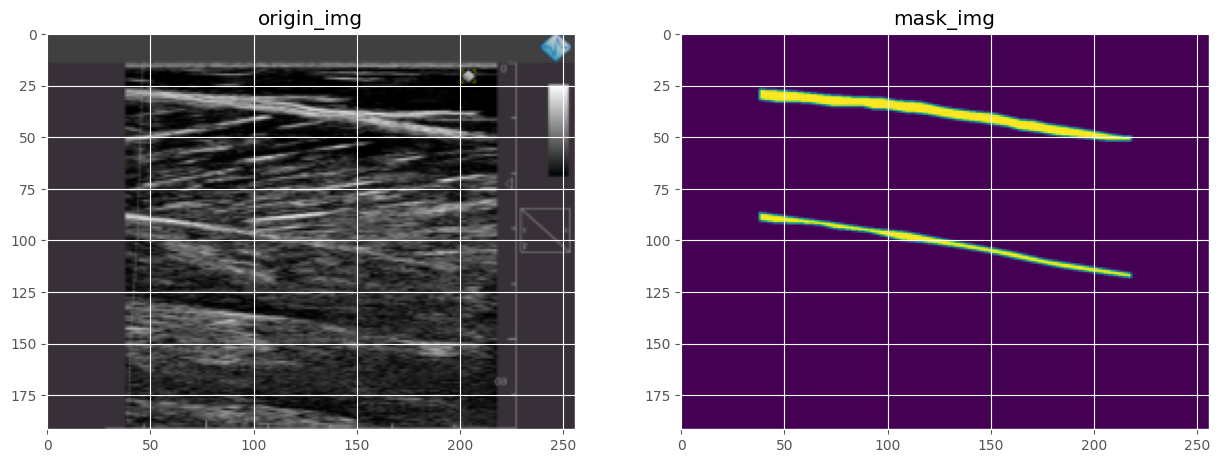

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## Transfuse
> https://github.com/Rayicer/TransFuse

### transformer.py

In [9]:

import torch
import torch.nn as nn
from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained

from timm.models.registry import register_model
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        #assert H == self.img_size[0] and W == self.img_size[1], \
        #    f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=2, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _conv_filter(state_dict, patch_size=2):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    if pretrained:
        # NOTE my scale was wrong for original weights, leaving this here until I have better ones for this model
        kwargs.setdefault('qk_scale', 768 ** -0.5)
    model = VisionTransformer(patch_size=2, embed_dim=768, depth=8, num_heads=8, mlp_ratio=3., **kwargs)
#     model.default_cfg = default_cfgs['vit_small_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_224']
    if pretrained:
        load_pretrained(
            model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3), filter_fn=_conv_filter)
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_base_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_base_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_224']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=2, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch16_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_large_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,  qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = default_cfgs['vit_large_patch32_384']
    if pretrained:
        load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(patch_size=2, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch16_224']
    return model


@register_model
def vit_huge_patch32_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=32, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, **kwargs)
#     model.default_cfg = default_cfgs['vit_huge_patch32_384']
    return model


### DeiT.py

In [10]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial

# from .vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_
import torch.nn.functional as F
import numpy as np


__all__ = [
    'deit_tiny_patch16_224', 'deit_small_patch16_224', 'deit_base_patch16_224',
    'deit_tiny_distilled_patch16_224', 'deit_small_distilled_patch16_224',
    'deit_base_distilled_patch16_224', 'deit_base_patch16_384',
    'deit_base_distilled_patch16_384',
]


class DeiT(VisionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))

    def forward(self, x):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        B = x.shape[0]
        x = self.patch_embed(x)
        pe = self.pos_embed

        x = x + pe
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x


@register_model
def deit_small_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=16, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_small_patch16_224-cd65a155.pth')
        model.load_state_dict(ckpt['model'], strict=False)
    
    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_224(pretrained=False, **kwargs):
    model = DeiT(
        patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_224-b5f2ef4d.pth')
        model.load_state_dict(ckpt['model'], strict=False)

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(12, 16), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model


@register_model
def deit_base_patch16_384(pretrained=False, **kwargs):
    model = DeiT(
        img_size=384, patch_size=2, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     model.default_cfg = _cfg()
    if pretrained:
        ckpt = torch.load('pretrained/deit_base_patch16_384-8de9b5d1.pth')
        model.load_state_dict(ckpt["model"])

    pe = model.pos_embed[:, 1:, :].detach()
    pe = pe.transpose(-1, -2)
    pe = pe.view(pe.shape[0], pe.shape[1], int(np.sqrt(pe.shape[2])), int(np.sqrt(pe.shape[2])))
    pe = F.interpolate(pe, size=(24, 32), mode='bilinear', align_corners=True)
    pe = pe.flatten(2)
    pe = pe.transpose(-1, -2)
    model.pos_embed = nn.Parameter(pe)
    model.head = nn.Identity()
    return model

### transfuse.py

In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.models import resnet50
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import torch.nn.functional as F
import numpy as np
import math
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class BiFusion_block(nn.Module):
    def __init__(self, ch_1, ch_2, r_2, ch_int, ch_out, drop_rate=0.):
        super(BiFusion_block, self).__init__()

        # channel attention for F_g, use SE Block
        self.fc1 = nn.Conv2d(ch_2, ch_2 // r_2, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(ch_2 // r_2, ch_2, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # spatial attention for F_l
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, 7, bn=True, relu=False, bias=False)

        # bi-linear modelling for both
        self.W_g = Conv(ch_1, ch_int, 1, bn=True, relu=False)
        self.W_x = Conv(ch_2, ch_int, 1, bn=True, relu=False)
        self.W = Conv(ch_int, ch_int, 3, bn=True, relu=True)

        self.relu = nn.ReLU(inplace=True)

        self.residual = Residual(ch_1+ch_2+ch_int, ch_out)

        self.dropout = nn.Dropout2d(drop_rate)
        self.drop_rate = drop_rate

        
    def forward(self, g, x):
        # bilinear pooling
        W_g = self.W_g(g)
        W_x = self.W_x(x)
        bp = self.W(W_g*W_x)

        # spatial attention for cnn branch
        g_in = g
        g = self.compress(g)
        g = self.spatial(g)
        g = self.sigmoid(g) * g_in

        # channel attetion for transformer branch
        x_in = x
        x = x.mean((2, 3), keepdim=True)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x) * x_in
        fuse = self.residual(torch.cat([g, x, bp], 1))

        if self.drop_rate > 0:
            return self.dropout(fuse)
        else:
            return fuse


class TransFuse_S(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_S, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3

        self.resnet = resnet34()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet34-333f7ec4.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_small_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=384, out_ch=128)
        self.up2 = Up(128, 64)

        self.final_x = nn.Sequential(
            Conv(256, 64, 1, bn=True, relu=True),
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(64, 64, 3, bn=True, relu=True),
            Conv(64, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=256, ch_2=384, r_2=4, ch_int=256, ch_out=256, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=128, ch_2=128, r_2=2, ch_int=128, ch_out=128, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=256, out_ch=128, in_ch2=128, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=64, ch_2=64, r_2=1, ch_int=64, ch_out=64, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(128, 64, 64, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)

        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u) 

        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here

        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)
        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


class TransFuse_L(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
            
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_224(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 12, 16)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)
        

class TransFuse_L_384(nn.Module):
    def __init__(self, num_classes=1, drop_rate=0.2, normal_init=True, pretrained=False):
        super(TransFuse_L_384, self).__init__()
        self.n_classes = num_classes
        self.n_channels = 3
        
        self.resnet = resnet50()
        if pretrained:
            self.resnet.load_state_dict(torch.load('pretrained/resnet50-19c8e357.pth'))
        self.resnet.fc = nn.Identity()
        self.resnet.layer4 = nn.Identity()

        self.transformer = deit_base_patch16_384(pretrained=pretrained)

        self.up1 = Up(in_ch1=768, out_ch=512)
        self.up2 = Up(512, 256)

        self.final_x = nn.Sequential(
            Conv(1024, 256, 1, bn=True, relu=True),
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_1 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.final_2 = nn.Sequential(
            Conv(256, 256, 3, bn=True, relu=True),
            Conv(256, num_classes, 3, bn=False, relu=False)
            )

        self.up_c = BiFusion_block(ch_1=1024, ch_2=768, r_2=4, ch_int=1024, ch_out=1024, drop_rate=drop_rate/2)

        self.up_c_1_1 = BiFusion_block(ch_1=512, ch_2=512, r_2=2, ch_int=512, ch_out=512, drop_rate=drop_rate/2)
        self.up_c_1_2 = Up(in_ch1=1024, out_ch=512, in_ch2=512, attn=True)

        self.up_c_2_1 = BiFusion_block(ch_1=256, ch_2=256, r_2=1, ch_int=256, ch_out=256, drop_rate=drop_rate/2)
        self.up_c_2_2 = Up(512, 256, 256, attn=True)

        self.drop = nn.Dropout2d(drop_rate)

        if normal_init:
            self.init_weights()

    def forward(self, imgs, labels=None):
        # bottom-up path
        x_b = self.transformer(imgs)
        x_b = torch.transpose(x_b, 1, 2)
        x_b = x_b.view(x_b.shape[0], -1, 24, 32)
        x_b = self.drop(x_b)

        x_b_1 = self.up1(x_b)
        x_b_1 = self.drop(x_b_1)

        x_b_2 = self.up2(x_b_1)  # transformer pred supervise here
        x_b_2 = self.drop(x_b_2)


        # top-down path
        x_u = self.resnet.conv1(imgs)
        x_u = self.resnet.bn1(x_u)
        x_u = self.resnet.relu(x_u)
        x_u = self.resnet.maxpool(x_u)

        x_u_2 = self.resnet.layer1(x_u)
        x_u_2 = self.drop(x_u_2)

        x_u_1 = self.resnet.layer2(x_u_2)
        x_u_1 = self.drop(x_u_1)

        x_u = self.resnet.layer3(x_u_1)
        x_u = self.drop(x_u)


        # joint path
        x_c = self.up_c(x_u, x_b)

        x_c_1_1 = self.up_c_1_1(x_u_1, x_b_1)
        x_c_1 = self.up_c_1_2(x_c, x_c_1_1)

        x_c_2_1 = self.up_c_2_1(x_u_2, x_b_2)
        x_c_2 = self.up_c_2_2(x_c_1, x_c_2_1) # joint predict low supervise here


        # decoder part
        map_x = F.interpolate(self.final_x(x_c), scale_factor=16, mode='bilinear', align_corners=True)
        map_1 = F.interpolate(self.final_1(x_b_2), scale_factor=4, mode='bilinear', align_corners=True)
        map_2 = F.interpolate(self.final_2(x_c_2), scale_factor=4, mode='bilinear', align_corners=True)

        return map_x, map_1, map_2

    def init_weights(self):
        self.up1.apply(init_weights)
        self.up2.apply(init_weights)
        self.final_x.apply(init_weights)
        self.final_1.apply(init_weights)
        self.final_2.apply(init_weights)
        self.up_c.apply(init_weights)
        self.up_c_1_1.apply(init_weights)
        self.up_c_1_2.apply(init_weights)
        self.up_c_2_1.apply(init_weights)
        self.up_c_2_2.apply(init_weights)


def init_weights(m):
    """
    Initialize weights of layers using Kaiming Normal (He et al.) as argument of "Apply" function of
    "nn.Module"
    :param m: Layer to initialize
    :return: None
    """
    if isinstance(m, nn.Conv2d):
        '''
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        trunc_normal_(m.weight, std=math.sqrt(1.0/fan_in)/.87962566103423978)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        '''
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)
        
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_ch1, out_ch, in_ch2=0, attn=False):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch1+in_ch2, out_ch)

        if attn:
            self.attn_block = Attention_block(in_ch1, in_ch2, out_ch)
        else:
            self.attn_block = None

    def forward(self, x1, x2=None):

        x1 = self.up(x1)
        # input is CHW
        if x2 is not None:
            diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
            diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])

            if self.attn_block is not None:
                x2 = self.attn_block(x1, x2)
            x1 = torch.cat([x2, x1], dim=1)
        x = x1
        return self.conv(x)


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        return x*psi


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.identity = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
                nn.BatchNorm2d(out_channels)
                )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.double_conv(x)+self.identity(x))


class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 


class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride=1, bn=False, relu=True, bias=True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=bias)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU(inplace=True)
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

## 模型测试

In [12]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            
            lateral_map_4, lateral_map_3, lateral_map_2 = net(image)

            loss4 = criterion(lateral_map_4, mask_true.float())
            loss4 += dice_loss(lateral_map_4, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_4, mask_true.long(), mode='binary', threshold=0.5)
            iou_score = 0.5 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            loss3 = criterion(lateral_map_3, mask_true.float())
            loss3 += dice_loss(lateral_map_3, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_3, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += 0.3 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            loss2 = criterion(lateral_map_2, mask_true.float())
            loss2 += dice_loss(lateral_map_2, mask_true)
            tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_2, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += 0.2 *smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            dice_score += (0.5 * loss2 + 0.3 * loss3 + 0.2 * loss4)
            
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 模型训练

In [13]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model,
          device,
          project='U-Net',
          n_classes=1,
          n_channels=3,
          epochs: int = 60,
          learning_rate: float = 1e-5,
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    # if isinstance(model, nn.DataParallel):
        # n_classes = model.module.n_classes
        # n_channels = model.module.n_channels
    # else:
        # n_classes = model.n_classes
        # n_channels = model.n_channels

    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
    #                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

    # criterion = nn.CrossEntropyLoss().cuda()
    # dice_loss = smp.losses.DiceLoss(mode='binary').cuda()

    criterion = nn.CrossEntropyLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')

    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)

                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    lateral_map_4, lateral_map_3, lateral_map_2 = model(images)

                    loss4 = criterion(lateral_map_4, true_masks.float())
                    loss4 += dice_loss(lateral_map_4, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_4, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = 0.5 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss3 = criterion(lateral_map_3, true_masks.float())
                    loss3 += dice_loss(lateral_map_3, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_3, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score += 0.3 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss2 = criterion(lateral_map_2, true_masks.float())
                    loss2 += dice_loss(lateral_map_2, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(lateral_map_2, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score += 0.2 * smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

                    loss = 0.5 * loss2 + 0.3 * loss3 + 0.2 * loss4


                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        # for tag, value in model.named_parameters():
                        #     tag = tag.replace('/', '.')
                        #     if not (torch.isinf(value) | torch.isnan(value)).any():
                        #         histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                        #     if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                        #         histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(lateral_map_2[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass




## train transfuse

In [14]:
model = TransFuse_S(pretrained=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)

train(model, device, project='Transfuse')


wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231016_181821-sacvkek1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run northern-capybara-25
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/Transfuse
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/Transfuse/runs/sacvkek1
Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.40batch/s]


Validation dice loss: 3.1388754844665527, IoU Score 0.0002361055085202679


Epoch 1/60:  40%|███▉      | 182/456 [00:23<02:38,  1.73img/s, loss (batch)=0.928]

Validation dice loss: 2.992253541946411, IoU Score 0.0005169237265363336


Epoch 1/60:  60%|█████▉    | 272/456 [00:32<01:41,  1.82img/s, loss (batch)=0.88] 

Validation dice loss: 2.5518529415130615, IoU Score 0.0009572878479957581


Epoch 1/60:  79%|███████▉  | 362/456 [00:40<00:50,  1.87img/s, loss (batch)=0.793]

Validation dice loss: 2.1063053607940674, IoU Score 0.000981982797384262


Epoch 1/60:  99%|█████████▉| 452/456 [00:48<00:02,  1.77img/s, loss (batch)=0.809]

Validation dice loss: 1.696982979774475, IoU Score 0.0013406381476670504


Epoch 2/60:  19%|█▉        | 86/456 [00:08<03:22,  1.82img/s, loss (batch)=0.706]

Validation dice loss: 1.5358517169952393, IoU Score 0.00152520090341568


Epoch 2/60:  39%|███▊      | 176/456 [00:16<02:33,  1.83img/s, loss (batch)=0.729]

Validation dice loss: 1.4783827066421509, IoU Score 0.0016022631898522377


Epoch 2/60:  58%|█████▊    | 266/456 [00:24<01:46,  1.79img/s, loss (batch)=0.657]

Validation dice loss: 1.4180740118026733, IoU Score 0.0016208156011998653


Epoch 2/60:  78%|███████▊  | 356/456 [00:32<00:54,  1.85img/s, loss (batch)=0.714]

Validation dice loss: 1.4434797763824463, IoU Score 0.002239848952740431


Epoch 2/60:  98%|█████████▊| 446/456 [00:41<00:05,  1.80img/s, loss (batch)=0.767]

Validation dice loss: 1.3872992992401123, IoU Score 0.0023431330919265747


Epoch 3/60:  18%|█▊        | 80/456 [00:07<03:23,  1.84img/s, loss (batch)=0.574]

Validation dice loss: 1.2944380044937134, IoU Score 0.0024087524507194757


Epoch 3/60:  37%|███▋      | 170/456 [00:15<02:38,  1.80img/s, loss (batch)=0.517]

Validation dice loss: 1.2148922681808472, IoU Score 0.0020735524594783783


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.30batch/s]


Validation dice loss: 1.228198766708374, IoU Score 0.002581576118245721


Epoch 3/60:  77%|███████▋  | 350/456 [00:32<00:47,  2.24img/s, loss (batch)=0.649]

Validation dice loss: 1.1817176342010498, IoU Score 0.0023361751809716225


Epoch 3/60:  96%|█████████▋| 440/456 [00:40<00:08,  1.85img/s, loss (batch)=0.525]

Validation dice loss: 1.1807307004928589, IoU Score 0.002377681201323867


Epoch 4/60:  16%|█▌        | 74/456 [00:07<03:28,  1.83img/s, loss (batch)=0.581]

Validation dice loss: 1.1562100648880005, IoU Score 0.002231254708021879


Epoch 4/60:  36%|███▌      | 164/456 [00:15<03:05,  1.57img/s, loss (batch)=0.577]

Validation dice loss: 1.1212044954299927, IoU Score 0.002576410071924329


Epoch 4/60:  56%|█████▌    | 254/456 [00:24<01:53,  1.77img/s, loss (batch)=0.581]

Validation dice loss: 1.1293710470199585, IoU Score 0.0022895915899425745


Epoch 4/60:  75%|███████▌  | 344/456 [00:32<01:00,  1.84img/s, loss (batch)=0.474]

Validation dice loss: 1.1029986143112183, IoU Score 0.0024252375587821007


Epoch 4/60:  95%|█████████▌| 434/456 [00:40<00:12,  1.82img/s, loss (batch)=0.762]

Validation dice loss: 1.1205681562423706, IoU Score 0.0025463150814175606


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.23batch/s]


Validation dice loss: 1.0352305173873901, IoU Score 0.002462388016283512


Epoch 5/60:  35%|███▍      | 158/456 [00:15<02:42,  1.83img/s, loss (batch)=0.466]

Validation dice loss: 1.0696702003479004, IoU Score 0.0027210789266973734


Epoch 5/60:  54%|█████▍    | 248/456 [00:23<01:56,  1.79img/s, loss (batch)=0.513]

Validation dice loss: 1.0278829336166382, IoU Score 0.002512037055566907


Epoch 5/60:  74%|███████▍  | 338/456 [00:31<00:55,  2.13img/s, loss (batch)=0.48] 

Validation dice loss: 1.0680896043777466, IoU Score 0.002849089913070202


Epoch 5/60:  94%|█████████▍| 428/456 [00:40<00:16,  1.67img/s, loss (batch)=0.681]

Validation dice loss: 1.0016242265701294, IoU Score 0.0026693688705563545


Epoch 6/60:  14%|█▎        | 62/456 [00:06<03:33,  1.84img/s, loss (batch)=0.597]

Validation dice loss: 0.9878802299499512, IoU Score 0.0027519064024090767


Epoch 6/60:  33%|███▎      | 152/456 [00:14<02:46,  1.82img/s, loss (batch)=0.548]

Validation dice loss: 1.0635508298873901, IoU Score 0.0029135546647012234


Epoch 6/60:  53%|█████▎    | 242/456 [00:22<01:59,  1.79img/s, loss (batch)=0.605]

Validation dice loss: 1.0248552560806274, IoU Score 0.002610080176964402


Epoch 6/60:  73%|███████▎  | 332/456 [00:31<01:10,  1.76img/s, loss (batch)=0.511]

Validation dice loss: 1.0095059871673584, IoU Score 0.0027377360966056585


Epoch 6/60:  93%|█████████▎| 422/456 [00:39<00:19,  1.78img/s, loss (batch)=0.456]

Validation dice loss: 1.0160198211669922, IoU Score 0.0030139160808175802


Epoch 7/60:  12%|█▏        | 56/456 [00:06<03:37,  1.84img/s, loss (batch)=0.476]

Validation dice loss: 1.0128930807113647, IoU Score 0.002927439520135522


Epoch 7/60:  32%|███▏      | 146/456 [00:14<02:47,  1.85img/s, loss (batch)=0.481]

Validation dice loss: 0.9686515927314758, IoU Score 0.0029481903184205294


Epoch 7/60:  52%|█████▏    | 236/456 [00:22<02:02,  1.80img/s, loss (batch)=0.552]

Validation dice loss: 1.0518206357955933, IoU Score 0.0029042584355920553


Epoch 7/60:  71%|███████▏  | 326/456 [00:31<01:13,  1.77img/s, loss (batch)=0.812]

Validation dice loss: 1.0466595888137817, IoU Score 0.0030023683793842793


Epoch 7/60:  91%|█████████ | 416/456 [00:39<00:22,  1.80img/s, loss (batch)=0.441]

Validation dice loss: 1.045398473739624, IoU Score 0.003050918458029628


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.74batch/s]


Validation dice loss: 1.0572112798690796, IoU Score 0.003064995165914297


Epoch 8/60:  31%|███       | 140/456 [00:14<02:53,  1.82img/s, loss (batch)=0.62] 

Validation dice loss: 0.9995145201683044, IoU Score 0.003203845117241144


Epoch 8/60:  50%|█████     | 230/456 [00:22<02:05,  1.81img/s, loss (batch)=0.496]

Validation dice loss: 1.0894136428833008, IoU Score 0.003235806478187442


Epoch 8/60:  70%|███████   | 320/456 [00:31<01:15,  1.81img/s, loss (batch)=0.614]

Validation dice loss: 1.0584731101989746, IoU Score 0.0032604397274553776


Epoch 8/60:  90%|████████▉ | 410/456 [00:39<00:29,  1.55img/s, loss (batch)=0.575]

Validation dice loss: 0.9641630053520203, IoU Score 0.003112784121185541


Epoch 9/60:  10%|▉         | 44/456 [00:05<03:51,  1.78img/s, loss (batch)=0.589]

Validation dice loss: 1.083836555480957, IoU Score 0.0032566161826252937


Epoch 9/60:  29%|██▉       | 134/456 [00:13<02:57,  1.82img/s, loss (batch)=0.495]

Validation dice loss: 0.873094379901886, IoU Score 0.00316603877581656


Epoch 9/60:  49%|████▉     | 224/456 [00:21<02:07,  1.82img/s, loss (batch)=0.465]

Validation dice loss: 0.8912853598594666, IoU Score 0.0032460703514516354


Epoch 9/60:  69%|██████▉   | 314/456 [00:30<01:30,  1.57img/s, loss (batch)=0.526]

Validation dice loss: 1.0340461730957031, IoU Score 0.0031749384943395853


Epoch 9/60:  89%|████████▊ | 404/456 [00:38<00:28,  1.83img/s, loss (batch)=0.42] 

Validation dice loss: 1.0695858001708984, IoU Score 0.003533619688823819


Epoch 10/60:   8%|▊         | 38/456 [00:05<03:16,  2.12img/s, loss (batch)=0.644]

Validation dice loss: 0.9356434345245361, IoU Score 0.003455455182120204


Epoch 10/60:  28%|██▊       | 128/456 [00:13<03:16,  1.67img/s, loss (batch)=0.361]

Validation dice loss: 1.0013148784637451, IoU Score 0.0031027174554765224


Epoch 10/60:  48%|████▊     | 218/456 [00:22<01:58,  2.01img/s, loss (batch)=0.414]

Validation dice loss: 0.9755356907844543, IoU Score 0.0033711413852870464


Epoch 10/60:  68%|██████▊   | 308/456 [00:30<01:20,  1.83img/s, loss (batch)=0.419]

Validation dice loss: 1.0163754224777222, IoU Score 0.0035221760626882315


Epoch 10/60:  87%|████████▋ | 398/456 [00:38<00:28,  2.07img/s, loss (batch)=0.73] 

Validation dice loss: 1.0578981637954712, IoU Score 0.0036495684180408716


Epoch 11/60:   7%|▋         | 32/456 [00:05<04:07,  1.71img/s, loss (batch)=0.678]

Validation dice loss: 0.9730211496353149, IoU Score 0.003639554139226675


Epoch 11/60:  27%|██▋       | 122/456 [00:14<03:11,  1.75img/s, loss (batch)=0.468]

Validation dice loss: 1.0141881704330444, IoU Score 0.003546196734532714


Epoch 11/60:  46%|████▋     | 212/456 [00:22<02:16,  1.79img/s, loss (batch)=0.394]

Validation dice loss: 0.9571975469589233, IoU Score 0.0035326890647411346


Epoch 11/60:  66%|██████▌   | 302/456 [00:30<01:24,  1.82img/s, loss (batch)=0.494]

Validation dice loss: 0.9702242612838745, IoU Score 0.0036134046968072653


Epoch 11/60:  86%|████████▌ | 392/456 [00:38<00:38,  1.68img/s, loss (batch)=0.442]

Validation dice loss: 0.9264200329780579, IoU Score 0.003475294215604663


Epoch 12/60:   6%|▌         | 26/456 [00:04<03:53,  1.84img/s, loss (batch)=0.369]

Validation dice loss: 1.1305863857269287, IoU Score 0.003537745913490653


Epoch 12/60:  25%|██▌       | 116/456 [00:12<03:04,  1.84img/s, loss (batch)=0.468]

Validation dice loss: 0.9461775422096252, IoU Score 0.003430219367146492


Epoch 12/60:  45%|████▌     | 206/456 [00:21<02:29,  1.68img/s, loss (batch)=0.451]

Validation dice loss: 0.8980953693389893, IoU Score 0.0035048723220825195


Epoch 12/60:  65%|██████▍   | 296/456 [00:29<01:42,  1.56img/s, loss (batch)=0.316]

Validation dice loss: 1.1282202005386353, IoU Score 0.0038130178581923246


Epoch 12/60:  85%|████████▍ | 386/456 [00:37<00:38,  1.81img/s, loss (batch)=0.378]

Validation dice loss: 0.928324818611145, IoU Score 0.003664399031549692


Epoch 13/60:   4%|▍         | 20/456 [00:04<04:00,  1.82img/s, loss (batch)=0.417]

Validation dice loss: 1.059299111366272, IoU Score 0.0036527926567941904


Epoch 13/60:  24%|██▍       | 110/456 [00:12<03:15,  1.77img/s, loss (batch)=0.394]

Validation dice loss: 0.897739052772522, IoU Score 0.003748351475223899


Epoch 13/60:  44%|████▍     | 200/456 [00:21<02:42,  1.58img/s, loss (batch)=0.482]

Validation dice loss: 0.881073534488678, IoU Score 0.0035565600264817476


Epoch 13/60:  64%|██████▎   | 290/456 [00:29<01:33,  1.78img/s, loss (batch)=0.376]

Validation dice loss: 0.9118438959121704, IoU Score 0.0037126438692212105


Epoch 13/60:  83%|████████▎ | 380/456 [00:37<00:42,  1.77img/s, loss (batch)=0.492]

Validation dice loss: 0.9374567866325378, IoU Score 0.0038214209489524364


Epoch 14/60:   3%|▎         | 14/456 [00:04<04:02,  1.82img/s, loss (batch)=0.452]

Validation dice loss: 0.8112626075744629, IoU Score 0.0035421429201960564


Epoch 14/60:  23%|██▎       | 104/456 [00:12<03:16,  1.79img/s, loss (batch)=0.613]

Validation dice loss: 0.8875360488891602, IoU Score 0.0037466140929609537


Epoch 14/60:  43%|████▎     | 194/456 [00:20<02:18,  1.89img/s, loss (batch)=0.353]

Validation dice loss: 0.9769987463951111, IoU Score 0.0037663292605429888


Epoch 14/60:  62%|██████▏   | 284/456 [00:29<01:41,  1.69img/s, loss (batch)=0.603]

Validation dice loss: 0.9980097413063049, IoU Score 0.003961886744946241


Epoch 14/60:  82%|████████▏ | 374/456 [00:37<00:46,  1.76img/s, loss (batch)=0.354]

Validation dice loss: 0.9137566089630127, IoU Score 0.003744008019566536


Epoch 15/60:   2%|▏         | 8/456 [00:03<05:01,  1.49img/s, loss (batch)=0.508]

Validation dice loss: 0.9812415838241577, IoU Score 0.00405868049710989


Epoch 15/60:  21%|██▏       | 98/456 [00:11<03:18,  1.81img/s, loss (batch)=0.456]

Validation dice loss: 0.9579859972000122, IoU Score 0.00371210346929729


Epoch 15/60:  41%|████      | 188/456 [00:20<02:33,  1.75img/s, loss (batch)=0.327]

Validation dice loss: 0.8353074789047241, IoU Score 0.0037519405595958233


Epoch 15/60:  61%|██████    | 278/456 [00:28<01:37,  1.83img/s, loss (batch)=0.682]

Validation dice loss: 0.9332594871520996, IoU Score 0.003825585823506117


Epoch 15/60:  81%|████████  | 368/456 [00:36<00:48,  1.82img/s, loss (batch)=0.384]

Validation dice loss: 0.8322863578796387, IoU Score 0.003961233422160149


Epoch 15/60: 100%|██████████| 456/456 [00:45<00:00, 10.11img/s, loss (batch)=0.486]


Validation dice loss: 0.9219697713851929, IoU Score 0.004000239539891481


Epoch 16/60:  20%|██        | 92/456 [00:08<03:26,  1.76img/s, loss (batch)=0.36] 

Validation dice loss: 0.8033086061477661, IoU Score 0.0038615907542407513


Epoch 16/60:  40%|███▉      | 182/456 [00:17<02:51,  1.59img/s, loss (batch)=0.359]

Validation dice loss: 0.9874202609062195, IoU Score 0.004004571586847305


Epoch 16/60:  60%|█████▉    | 272/456 [00:25<01:41,  1.81img/s, loss (batch)=0.545]

Validation dice loss: 0.8763364553451538, IoU Score 0.003952533006668091


Epoch 16/60:  79%|███████▉  | 362/456 [00:33<00:58,  1.62img/s, loss (batch)=0.477]

Validation dice loss: 0.8797956109046936, IoU Score 0.0038422553334385157


Epoch 16/60:  99%|█████████▉| 452/456 [00:42<00:02,  1.80img/s, loss (batch)=0.304]

Validation dice loss: 0.9499561786651611, IoU Score 0.0039201523177325726


Epoch 17/60:  19%|█▉        | 86/456 [00:08<03:53,  1.58img/s, loss (batch)=0.58]

Validation dice loss: 0.7516160607337952, IoU Score 0.0038533147890120745


Epoch 17/60:  39%|███▊      | 176/456 [00:16<02:39,  1.76img/s, loss (batch)=0.393]

Validation dice loss: 0.8108746409416199, IoU Score 0.003915713634341955


Epoch 17/60:  58%|█████▊    | 266/456 [00:24<01:47,  1.76img/s, loss (batch)=0.427]

Validation dice loss: 0.8292202353477478, IoU Score 0.004063067492097616


Epoch 17/60:  78%|███████▊  | 356/456 [00:32<00:54,  1.83img/s, loss (batch)=0.318]

Validation dice loss: 1.042218565940857, IoU Score 0.00391061045229435


Epoch 17/60:  98%|█████████▊| 446/456 [00:41<00:05,  1.78img/s, loss (batch)=0.371]

Validation dice loss: 0.8871616125106812, IoU Score 0.003929016180336475


Epoch 18/60:  18%|█▊        | 80/456 [00:07<03:28,  1.80img/s, loss (batch)=0.395]

Validation dice loss: 0.8172555565834045, IoU Score 0.0038286587223410606


Epoch 18/60:  37%|███▋      | 170/456 [00:16<02:43,  1.75img/s, loss (batch)=0.323]

Validation dice loss: 0.9565288424491882, IoU Score 0.004001719411462545


Epoch 18/60:  57%|█████▋    | 260/456 [00:24<01:50,  1.77img/s, loss (batch)=0.405]

Validation dice loss: 0.8289415240287781, IoU Score 0.0036922022700309753


Epoch 18/60:  77%|███████▋  | 350/456 [00:33<00:59,  1.79img/s, loss (batch)=0.515]

Validation dice loss: 0.8696762919425964, IoU Score 0.004038996063172817


Epoch 18/60:  96%|█████████▋| 440/456 [00:41<00:09,  1.67img/s, loss (batch)=0.31] 

Validation dice loss: 0.8111822009086609, IoU Score 0.003914245869964361


Epoch 19/60:  16%|█▌        | 74/456 [00:07<03:33,  1.79img/s, loss (batch)=0.376]

Validation dice loss: 0.9152684211730957, IoU Score 0.0034742369316518307


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.39batch/s]


Validation dice loss: 0.9051715731620789, IoU Score 0.004009399097412825


Epoch 19/60:  56%|█████▌    | 254/456 [00:23<01:52,  1.80img/s, loss (batch)=0.343]

Validation dice loss: 0.8314356803894043, IoU Score 0.003930699545890093


Epoch 19/60:  75%|███████▌  | 344/456 [00:32<01:10,  1.59img/s, loss (batch)=0.454]

Validation dice loss: 0.8485723733901978, IoU Score 0.004022411070764065


Epoch 19/60:  95%|█████████▌| 434/456 [00:40<00:12,  1.80img/s, loss (batch)=0.354]

Validation dice loss: 0.8296383023262024, IoU Score 0.004179893061518669


Epoch 20/60:  15%|█▍        | 68/456 [00:07<04:06,  1.58img/s, loss (batch)=0.298]

Validation dice loss: 0.7978469729423523, IoU Score 0.003943226300179958


Epoch 20/60:  35%|███▍      | 158/456 [00:15<02:45,  1.80img/s, loss (batch)=0.41] 

Validation dice loss: 0.8927285075187683, IoU Score 0.004080511629581451


Epoch 20/60:  54%|█████▍    | 248/456 [00:24<01:53,  1.83img/s, loss (batch)=0.366]

Validation dice loss: 0.845055103302002, IoU Score 0.004160505719482899


Epoch 20/60:  74%|███████▍  | 338/456 [00:32<01:05,  1.80img/s, loss (batch)=0.381]

Validation dice loss: 0.7992386817932129, IoU Score 0.004175674170255661


Epoch 20/60:  94%|█████████▍| 428/456 [00:41<00:17,  1.58img/s, loss (batch)=0.434]

Validation dice loss: 0.7893885970115662, IoU Score 0.004030534997582436


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.35batch/s]


Validation dice loss: 0.8009077310562134, IoU Score 0.003997665364295244


Validation round: 100%|██████████| 115/115 [00:03<00:00, 35.21batch/s]


Validation dice loss: 0.7623623013496399, IoU Score 0.0038381011690944433


Epoch 21/60:  53%|█████▎    | 242/456 [00:23<01:59,  1.80img/s, loss (batch)=0.323]

Validation dice loss: 0.8433316946029663, IoU Score 0.003970061428844929


Epoch 21/60:  73%|███████▎  | 332/456 [00:32<01:09,  1.79img/s, loss (batch)=0.444]

Validation dice loss: 0.8516833186149597, IoU Score 0.0040587326511740685


Epoch 21/60:  93%|█████████▎| 422/456 [00:40<00:21,  1.61img/s, loss (batch)=0.455]

Validation dice loss: 0.8900154232978821, IoU Score 0.0038095186464488506


Epoch 22/60:  12%|█▏        | 56/456 [00:06<03:43,  1.79img/s, loss (batch)=0.376]

Validation dice loss: 0.8293625116348267, IoU Score 0.004094819538295269


Epoch 22/60:  32%|███▏      | 146/456 [00:14<02:43,  1.89img/s, loss (batch)=0.234]

Validation dice loss: 0.8365938067436218, IoU Score 0.0040732575580477715


Epoch 22/60:  52%|█████▏    | 236/456 [00:23<02:06,  1.74img/s, loss (batch)=0.319]

Validation dice loss: 0.8192474246025085, IoU Score 0.004099140875041485


Epoch 22/60:  71%|███████▏  | 326/456 [00:31<01:13,  1.78img/s, loss (batch)=0.482]

Validation dice loss: 0.7546370625495911, IoU Score 0.004057004582136869


Epoch 22/60:  91%|█████████ | 416/456 [00:39<00:22,  1.78img/s, loss (batch)=0.37] 

Validation dice loss: 0.7968664765357971, IoU Score 0.004145722836256027


Epoch 23/60:  11%|█         | 50/456 [00:06<04:16,  1.58img/s, loss (batch)=0.438]

Validation dice loss: 0.8645879626274109, IoU Score 0.004001520108431578


Epoch 23/60:  31%|███       | 140/456 [00:14<02:56,  1.79img/s, loss (batch)=0.321]

Validation dice loss: 0.7998320460319519, IoU Score 0.004109575413167477


Epoch 23/60:  50%|█████     | 230/456 [00:23<02:07,  1.77img/s, loss (batch)=0.286]

Validation dice loss: 0.7736783623695374, IoU Score 0.004146713763475418


Epoch 23/60:  70%|███████   | 320/456 [00:31<01:17,  1.76img/s, loss (batch)=0.498]

Validation dice loss: 0.8132032155990601, IoU Score 0.004242549184709787


Epoch 23/60:  90%|████████▉ | 410/456 [00:40<00:28,  1.63img/s, loss (batch)=0.672]

Validation dice loss: 0.9444555640220642, IoU Score 0.004159577656537294


Epoch 24/60:  10%|▉         | 44/456 [00:06<04:18,  1.59img/s, loss (batch)=0.288]

Validation dice loss: 0.9855956435203552, IoU Score 0.004085766151547432


Epoch 24/60:  29%|██▉       | 134/456 [00:14<02:57,  1.81img/s, loss (batch)=0.417]

Validation dice loss: 0.8796648383140564, IoU Score 0.004083155654370785


Epoch 24/60:  49%|████▉     | 224/456 [00:22<02:05,  1.85img/s, loss (batch)=0.397]

Validation dice loss: 0.8472347259521484, IoU Score 0.00427932059392333


Epoch 24/60:  69%|██████▉   | 314/456 [00:30<01:21,  1.75img/s, loss (batch)=0.379]

Validation dice loss: 0.775607168674469, IoU Score 0.004164618905633688


Epoch 24/60:  89%|████████▊ | 404/456 [00:39<00:30,  1.71img/s, loss (batch)=0.297]

Validation dice loss: 0.7801302075386047, IoU Score 0.004168104380369186


Epoch 25/60:   8%|▊         | 38/456 [00:05<03:50,  1.81img/s, loss (batch)=0.299]

Validation dice loss: 0.7906501293182373, IoU Score 0.004140499047935009


Epoch 25/60:  28%|██▊       | 128/456 [00:13<03:01,  1.80img/s, loss (batch)=0.395]

Validation dice loss: 0.8348075151443481, IoU Score 0.0040899598971009254


Epoch 25/60:  48%|████▊     | 218/456 [00:22<02:07,  1.86img/s, loss (batch)=0.459]

Validation dice loss: 0.8069721460342407, IoU Score 0.004043568391352892


Epoch 25/60:  68%|██████▊   | 308/456 [00:30<01:22,  1.80img/s, loss (batch)=0.532]

Validation dice loss: 0.7435137629508972, IoU Score 0.004010590724647045


Epoch 25/60:  87%|████████▋ | 398/456 [00:38<00:32,  1.79img/s, loss (batch)=0.376]

Validation dice loss: 0.8203942179679871, IoU Score 0.004115106537938118


Epoch 26/60:   7%|▋         | 32/456 [00:05<04:34,  1.55img/s, loss (batch)=0.368]

Validation dice loss: 0.7679749131202698, IoU Score 0.004288236610591412


Validation round: 100%|██████████| 115/115 [00:03<00:00, 32.93batch/s]


Validation dice loss: 0.7580161094665527, IoU Score 0.004253228195011616


Epoch 26/60:  46%|████▋     | 212/456 [00:22<02:16,  1.79img/s, loss (batch)=0.271]

Validation dice loss: 0.8370216488838196, IoU Score 0.004028863273561001


Epoch 26/60:  66%|██████▌   | 302/456 [00:30<01:24,  1.83img/s, loss (batch)=0.41] 

Validation dice loss: 0.7568743228912354, IoU Score 0.003974609076976776


Epoch 26/60:  86%|████████▌ | 392/456 [00:39<00:40,  1.60img/s, loss (batch)=0.245]

Validation dice loss: 0.8549599051475525, IoU Score 0.004292364697903395


Epoch 27/60:   6%|▌         | 26/456 [00:05<04:32,  1.58img/s, loss (batch)=0.461]

Validation dice loss: 0.7565796971321106, IoU Score 0.004002360627055168


Epoch 27/60:  25%|██▌       | 116/456 [00:13<03:10,  1.78img/s, loss (batch)=0.258]

Validation dice loss: 0.7892881631851196, IoU Score 0.004256559535861015


Epoch 27/60:  45%|████▌     | 206/456 [00:21<02:14,  1.87img/s, loss (batch)=0.345]

Validation dice loss: 0.7244716286659241, IoU Score 0.004138023126870394


Epoch 27/60:  65%|██████▍   | 296/456 [00:29<01:28,  1.81img/s, loss (batch)=0.395]

Validation dice loss: 0.8165106177330017, IoU Score 0.004205266945064068


Epoch 27/60:  85%|████████▍ | 386/456 [00:38<00:39,  1.78img/s, loss (batch)=0.338]

Validation dice loss: 0.7385266423225403, IoU Score 0.004100142512470484


Epoch 28/60:   4%|▍         | 20/456 [00:04<04:09,  1.74img/s, loss (batch)=0.238]

Validation dice loss: 0.8781370520591736, IoU Score 0.0042804270051419735


Epoch 28/60:  24%|██▍       | 110/456 [00:12<03:13,  1.79img/s, loss (batch)=0.294]

Validation dice loss: 0.8117954730987549, IoU Score 0.0041620805859565735


Epoch 28/60:  44%|████▍     | 200/456 [00:21<02:25,  1.76img/s, loss (batch)=0.236]

Validation dice loss: 0.8166822195053101, IoU Score 0.004187947604805231


Epoch 28/60:  64%|██████▎   | 290/456 [00:29<01:33,  1.77img/s, loss (batch)=0.258]

Validation dice loss: 0.8362205028533936, IoU Score 0.004146328195929527


Epoch 28/60:  83%|████████▎ | 380/456 [00:37<00:41,  1.83img/s, loss (batch)=0.264]

Validation dice loss: 0.8497312068939209, IoU Score 0.00404951348900795


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.94batch/s]


Validation dice loss: 0.7950698733329773, IoU Score 0.004050029907375574


Validation round: 100%|██████████| 115/115 [00:03<00:00, 31.23batch/s]


Validation dice loss: 0.8381010293960571, IoU Score 0.0039926799945533276


Epoch 29/60:  43%|████▎     | 194/456 [00:21<02:26,  1.78img/s, loss (batch)=0.553]

Validation dice loss: 0.7858626842498779, IoU Score 0.00419136555865407


Epoch 29/60:  62%|██████▏   | 284/456 [00:29<01:37,  1.77img/s, loss (batch)=0.454]

Validation dice loss: 0.8082245588302612, IoU Score 0.004209230653941631


Epoch 29/60:  82%|████████▏ | 374/456 [00:38<00:53,  1.54img/s, loss (batch)=0.809]

Validation dice loss: 0.8273494839668274, IoU Score 0.004258160945028067


Epoch 30/60:   2%|▏         | 8/456 [00:04<05:54,  1.26img/s, loss (batch)=0.235]

Validation dice loss: 0.8314101099967957, IoU Score 0.003997867926955223


Epoch 30/60:  21%|██▏       | 98/456 [00:12<03:16,  1.82img/s, loss (batch)=0.245]

Validation dice loss: 0.7909587621688843, IoU Score 0.004221708979457617


Epoch 30/60:  41%|████      | 188/456 [00:20<02:29,  1.79img/s, loss (batch)=0.392]

Validation dice loss: 0.8065180778503418, IoU Score 0.0042671444825828075


Epoch 30/60:  61%|██████    | 278/456 [00:29<01:42,  1.73img/s, loss (batch)=0.619]

Validation dice loss: 0.7730664610862732, IoU Score 0.004165230318903923


Epoch 30/60:  81%|████████  | 368/456 [00:37<00:47,  1.84img/s, loss (batch)=0.269]

Validation dice loss: 0.8023698329925537, IoU Score 0.004010002128779888


Epoch 30/60: 100%|██████████| 456/456 [00:45<00:00,  9.93img/s, loss (batch)=0.393]


Validation dice loss: 0.7656771540641785, IoU Score 0.004200349096208811


Epoch 31/60:  20%|██        | 92/456 [00:08<03:06,  1.96img/s, loss (batch)=0.51] 

Validation dice loss: 0.796565055847168, IoU Score 0.004187540151178837


Epoch 31/60:  40%|███▉      | 182/456 [00:16<02:32,  1.80img/s, loss (batch)=0.307]

Validation dice loss: 0.863509476184845, IoU Score 0.004030299372971058


Epoch 31/60:  60%|█████▉    | 272/456 [00:25<01:39,  1.84img/s, loss (batch)=0.336]

Validation dice loss: 0.7681317329406738, IoU Score 0.004177860449999571


Epoch 31/60:  79%|███████▉  | 362/456 [00:33<00:53,  1.75img/s, loss (batch)=0.307]

Validation dice loss: 0.8071327209472656, IoU Score 0.004182472825050354


Epoch 31/60:  99%|█████████▉| 452/456 [00:41<00:02,  1.80img/s, loss (batch)=0.336]

Validation dice loss: 0.807854413986206, IoU Score 0.004103458486497402


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.81batch/s]


Validation dice loss: 0.8713550567626953, IoU Score 0.0040784054435789585


Epoch 32/60:  39%|███▊      | 176/456 [00:17<02:40,  1.75img/s, loss (batch)=0.388]

Validation dice loss: 0.8500480651855469, IoU Score 0.0040598539635539055


Epoch 32/60:  58%|█████▊    | 266/456 [00:25<01:43,  1.84img/s, loss (batch)=0.523]

Validation dice loss: 0.8102509379386902, IoU Score 0.004151738248765469


Epoch 32/60:  78%|███████▊  | 356/456 [00:34<01:04,  1.55img/s, loss (batch)=0.352]

Validation dice loss: 0.8450252413749695, IoU Score 0.0043624271638691425


Epoch 32/60:  98%|█████████▊| 446/456 [00:42<00:06,  1.55img/s, loss (batch)=0.274]

Validation dice loss: 0.7924724221229553, IoU Score 0.004103271756321192


Epoch 33/60:  18%|█▊        | 80/456 [00:07<03:26,  1.82img/s, loss (batch)=0.455]

Validation dice loss: 0.9399641752243042, IoU Score 0.004213232081383467


Epoch 33/60:  37%|███▋      | 170/456 [00:15<02:42,  1.76img/s, loss (batch)=0.293]

Validation dice loss: 0.8560516238212585, IoU Score 0.004126482177525759


Epoch 33/60:  57%|█████▋    | 260/456 [00:24<02:00,  1.62img/s, loss (batch)=0.341]

Validation dice loss: 0.9100149273872375, IoU Score 0.004113275092095137


Epoch 33/60:  77%|███████▋  | 350/456 [00:33<01:00,  1.76img/s, loss (batch)=0.43] 

Validation dice loss: 0.9265504479408264, IoU Score 0.004253264516592026


Epoch 33/60:  96%|█████████▋| 440/456 [00:41<00:08,  1.83img/s, loss (batch)=0.326]

Validation dice loss: 0.8136721253395081, IoU Score 0.004165713209658861


Epoch 34/60:  16%|█▌        | 74/456 [00:07<03:31,  1.80img/s, loss (batch)=0.313]

Validation dice loss: 0.8730931878089905, IoU Score 0.0040833172388374805


Epoch 34/60:  36%|███▌      | 164/456 [00:15<02:40,  1.82img/s, loss (batch)=0.315]

Validation dice loss: 0.8394196033477783, IoU Score 0.004255206789821386


Epoch 34/60:  56%|█████▌    | 254/456 [00:24<01:56,  1.74img/s, loss (batch)=0.382]

Validation dice loss: 0.8643028736114502, IoU Score 0.004077724181115627


Epoch 34/60:  75%|███████▌  | 344/456 [00:32<01:03,  1.76img/s, loss (batch)=0.286]

Validation dice loss: 0.8616543412208557, IoU Score 0.004238509107381105


Epoch 34/60:  95%|█████████▌| 434/456 [00:41<00:12,  1.75img/s, loss (batch)=0.315]

Validation dice loss: 0.8544865846633911, IoU Score 0.004164956044405699


Epoch 35/60:  15%|█▍        | 68/456 [00:07<03:56,  1.64img/s, loss (batch)=0.269]

Validation dice loss: 0.8980257511138916, IoU Score 0.004321161657571793


Epoch 35/60:  35%|███▍      | 158/456 [00:15<02:48,  1.77img/s, loss (batch)=0.426]

Validation dice loss: 0.8524448275566101, IoU Score 0.004262025933712721


Epoch 35/60:  54%|█████▍    | 248/456 [00:23<01:56,  1.78img/s, loss (batch)=0.351]

Validation dice loss: 0.8370400667190552, IoU Score 0.004081482067704201


Epoch 35/60:  74%|███████▍  | 338/456 [00:32<01:14,  1.57img/s, loss (batch)=0.378]

Validation dice loss: 0.8649278283119202, IoU Score 0.004241653252393007


Epoch 35/60:  94%|█████████▍| 428/456 [00:41<00:18,  1.48img/s, loss (batch)=0.747]

Validation dice loss: 0.8726565837860107, IoU Score 0.0042619225569069386


Epoch 36/60:  14%|█▎        | 62/456 [00:06<03:45,  1.75img/s, loss (batch)=0.38] 

Validation dice loss: 0.9247541427612305, IoU Score 0.004294892773032188


Epoch 36/60:  33%|███▎      | 152/456 [00:14<02:47,  1.81img/s, loss (batch)=0.488]

Validation dice loss: 0.8211746215820312, IoU Score 0.004180155228823423


Epoch 36/60:  53%|█████▎    | 242/456 [00:23<02:06,  1.69img/s, loss (batch)=0.256]

Validation dice loss: 0.7611185312271118, IoU Score 0.004213308449834585


Epoch 36/60:  73%|███████▎  | 332/456 [00:32<01:12,  1.71img/s, loss (batch)=0.27] 

Validation dice loss: 0.854007363319397, IoU Score 0.0041606915183365345


Epoch 36/60:  93%|█████████▎| 422/456 [00:40<00:18,  1.79img/s, loss (batch)=0.272]

Validation dice loss: 0.862429678440094, IoU Score 0.004303674679249525


Epoch 37/60:  12%|█▏        | 56/456 [00:06<03:47,  1.76img/s, loss (batch)=0.27]

Validation dice loss: 0.8841082453727722, IoU Score 0.004301097709685564


Epoch 37/60:  32%|███▏      | 146/456 [00:14<02:34,  2.01img/s, loss (batch)=0.279]

Validation dice loss: 0.874989926815033, IoU Score 0.004294761922210455


Epoch 37/60:  52%|█████▏    | 236/456 [00:23<02:05,  1.75img/s, loss (batch)=0.303]

Validation dice loss: 1.137557029724121, IoU Score 0.0044257487170398235


Epoch 37/60:  71%|███████▏  | 326/456 [00:31<01:12,  1.78img/s, loss (batch)=0.219]

Validation dice loss: 0.9264934659004211, IoU Score 0.004359788727015257


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.01batch/s]


Validation dice loss: 0.8095905780792236, IoU Score 0.0042793164029717445


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.04batch/s]


Validation dice loss: 0.8423196077346802, IoU Score 0.004338323138654232


Epoch 38/60:  31%|███       | 140/456 [00:14<02:52,  1.84img/s, loss (batch)=0.341]

Validation dice loss: 0.8915387392044067, IoU Score 0.0042708697728812695


Epoch 38/60:  50%|█████     | 230/456 [00:23<02:11,  1.72img/s, loss (batch)=0.355]

Validation dice loss: 0.8365650773048401, IoU Score 0.004330632276833057


Epoch 38/60:  70%|███████   | 320/456 [00:31<01:29,  1.53img/s, loss (batch)=0.347]

Validation dice loss: 0.8723993301391602, IoU Score 0.004277346655726433


Epoch 38/60:  90%|████████▉ | 410/456 [00:40<00:31,  1.47img/s, loss (batch)=0.399]

Validation dice loss: 0.845437228679657, IoU Score 0.004115835763514042


Epoch 39/60:  10%|▉         | 44/456 [00:05<03:46,  1.82img/s, loss (batch)=0.288]

Validation dice loss: 0.8006187677383423, IoU Score 0.004240116570144892


Epoch 39/60:  29%|██▉       | 134/456 [00:13<03:01,  1.77img/s, loss (batch)=0.324]

Validation dice loss: 0.9273000955581665, IoU Score 0.004244314972311258


Epoch 39/60:  49%|████▉     | 224/456 [00:22<02:08,  1.80img/s, loss (batch)=0.22] 

Validation dice loss: 0.818407416343689, IoU Score 0.004345741588622332


Epoch 39/60:  69%|██████▉   | 314/456 [00:31<01:26,  1.63img/s, loss (batch)=0.243]

Validation dice loss: 0.8168220520019531, IoU Score 0.004255174193531275


Epoch 39/60:  89%|████████▊ | 404/456 [00:39<00:29,  1.76img/s, loss (batch)=0.273]

Validation dice loss: 0.8303380608558655, IoU Score 0.0044228434562683105


Epoch 40/60:   8%|▊         | 38/456 [00:05<03:55,  1.77img/s, loss (batch)=0.25] 

Validation dice loss: 0.854712724685669, IoU Score 0.004418676719069481


Epoch 40/60:  28%|██▊       | 128/456 [00:13<03:03,  1.79img/s, loss (batch)=0.371]

Validation dice loss: 0.8336547613143921, IoU Score 0.0043506198562681675


Epoch 40/60:  48%|████▊     | 218/456 [00:22<02:11,  1.81img/s, loss (batch)=0.314]

Validation dice loss: 0.8316717743873596, IoU Score 0.004331544041633606


Epoch 40/60:  68%|██████▊   | 308/456 [00:30<01:22,  1.79img/s, loss (batch)=0.335]

Validation dice loss: 0.9147043228149414, IoU Score 0.004310945514589548


Epoch 40/60:  87%|████████▋ | 398/456 [00:39<00:35,  1.61img/s, loss (batch)=0.312]

Validation dice loss: 0.9015780687332153, IoU Score 0.004234091378748417


Epoch 41/60:   7%|▋         | 32/456 [00:05<03:57,  1.78img/s, loss (batch)=0.407]

Validation dice loss: 0.9041892886161804, IoU Score 0.004189828876405954


Epoch 41/60:  27%|██▋       | 122/456 [00:13<03:09,  1.76img/s, loss (batch)=0.425]

Validation dice loss: 0.8514808416366577, IoU Score 0.004216907545924187


Epoch 41/60:  46%|████▋     | 212/456 [00:21<02:16,  1.79img/s, loss (batch)=0.218]

Validation dice loss: 0.9173867106437683, IoU Score 0.004178465344011784


Epoch 41/60:  66%|██████▌   | 302/456 [00:30<01:37,  1.58img/s, loss (batch)=0.27] 

Validation dice loss: 0.8774691820144653, IoU Score 0.004441441036760807


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.82batch/s]


Validation dice loss: 0.9153879284858704, IoU Score 0.004191326908767223


Epoch 42/60:   6%|▌         | 26/456 [00:04<04:05,  1.75img/s, loss (batch)=0.256]

Validation dice loss: 0.9595632553100586, IoU Score 0.004193829372525215


Epoch 42/60:  25%|██▌       | 116/456 [00:12<03:07,  1.82img/s, loss (batch)=0.296]

Validation dice loss: 0.8677721619606018, IoU Score 0.004145307932049036


Epoch 42/60:  45%|████▌     | 206/456 [00:21<02:21,  1.76img/s, loss (batch)=0.262]

Validation dice loss: 0.9690818786621094, IoU Score 0.004170931875705719


Epoch 42/60:  65%|██████▍   | 296/456 [00:30<01:50,  1.45img/s, loss (batch)=0.397]

Validation dice loss: 0.8314914107322693, IoU Score 0.004079844802618027


Epoch 42/60:  85%|████████▍ | 386/456 [00:38<00:39,  1.76img/s, loss (batch)=0.806]

Validation dice loss: 0.7925319671630859, IoU Score 0.004144792910665274


Epoch 43/60:   4%|▍         | 20/456 [00:04<04:07,  1.76img/s, loss (batch)=0.371]

Validation dice loss: 0.8946198225021362, IoU Score 0.004228824749588966


Epoch 43/60:  24%|██▍       | 110/456 [00:13<03:06,  1.86img/s, loss (batch)=0.235]

Validation dice loss: 0.9467394351959229, IoU Score 0.004223540425300598


Epoch 43/60:  44%|████▍     | 200/456 [00:21<02:33,  1.66img/s, loss (batch)=0.273]

Validation dice loss: 1.0145784616470337, IoU Score 0.004164084326475859


Epoch 43/60:  64%|██████▎   | 290/456 [00:30<01:33,  1.78img/s, loss (batch)=0.33] 

Validation dice loss: 0.913089394569397, IoU Score 0.0043154312297701836


Epoch 43/60:  83%|████████▎ | 380/456 [00:38<00:49,  1.53img/s, loss (batch)=0.371]

Validation dice loss: 0.9626626968383789, IoU Score 0.004310579504817724


Epoch 44/60:   3%|▎         | 14/456 [00:04<04:24,  1.67img/s, loss (batch)=0.218]

Validation dice loss: 0.8960201740264893, IoU Score 0.004240825306624174


Epoch 44/60:  23%|██▎       | 104/456 [00:13<03:26,  1.71img/s, loss (batch)=0.189]

Validation dice loss: 0.8743438720703125, IoU Score 0.004143990576267242


Epoch 44/60:  43%|████▎     | 194/456 [00:21<02:27,  1.78img/s, loss (batch)=0.301]

Validation dice loss: 1.030322551727295, IoU Score 0.00430710706859827


Epoch 44/60:  62%|██████▏   | 284/456 [00:29<01:45,  1.64img/s, loss (batch)=0.333]

Validation dice loss: 0.927208423614502, IoU Score 0.004392202012240887


Epoch 44/60:  82%|████████▏ | 374/456 [00:38<00:46,  1.77img/s, loss (batch)=0.197]

Validation dice loss: 0.8809422850608826, IoU Score 0.004164758138358593


Epoch 45/60:   2%|▏         | 8/456 [00:03<05:25,  1.37img/s, loss (batch)=0.227]

Validation dice loss: 0.9395033121109009, IoU Score 0.0043103983625769615


Epoch 45/60:  21%|██▏       | 98/456 [00:11<03:02,  1.96img/s, loss (batch)=0.301]

Validation dice loss: 0.8323571681976318, IoU Score 0.004361075349152088


Epoch 45/60:  41%|████      | 188/456 [00:20<02:28,  1.80img/s, loss (batch)=0.336]

Validation dice loss: 0.9532235860824585, IoU Score 0.004367737099528313


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.08batch/s]


Validation dice loss: 0.8567320108413696, IoU Score 0.004384666681289673


Epoch 45/60:  81%|████████  | 368/456 [00:37<00:47,  1.85img/s, loss (batch)=0.421]

Validation dice loss: 0.8678207397460938, IoU Score 0.004293134901672602


Epoch 45/60: 100%|██████████| 456/456 [00:46<00:00,  9.88img/s, loss (batch)=0.317]


Validation dice loss: 0.8519321084022522, IoU Score 0.004346604458987713


Epoch 46/60:  20%|██        | 92/456 [00:08<03:22,  1.79img/s, loss (batch)=0.259]

Validation dice loss: 0.9015609622001648, IoU Score 0.0043090335093438625


Epoch 46/60:  40%|███▉      | 182/456 [00:17<03:12,  1.42img/s, loss (batch)=0.244]

Validation dice loss: 0.9657162427902222, IoU Score 0.004322105087339878


Epoch 46/60:  60%|█████▉    | 272/456 [00:25<01:42,  1.79img/s, loss (batch)=0.466]

Validation dice loss: 0.8916745185852051, IoU Score 0.004395568277686834


Epoch 46/60:  79%|███████▉  | 362/456 [00:34<01:00,  1.57img/s, loss (batch)=0.327]

Validation dice loss: 0.9652875661849976, IoU Score 0.004454329609870911


Epoch 46/60:  99%|█████████▉| 452/456 [00:42<00:02,  1.81img/s, loss (batch)=0.327]

Validation dice loss: 0.9702393412590027, IoU Score 0.004318683408200741


Epoch 47/60:  19%|█▉        | 86/456 [00:08<03:42,  1.67img/s, loss (batch)=0.346]

Validation dice loss: 0.8741087317466736, IoU Score 0.0044129337184131145


Epoch 47/60:  39%|███▊      | 176/456 [00:16<02:34,  1.81img/s, loss (batch)=0.3]  

Validation dice loss: 0.9005971550941467, IoU Score 0.004408941604197025


Epoch 47/60:  58%|█████▊    | 266/456 [00:25<01:47,  1.76img/s, loss (batch)=0.243]

Validation dice loss: 0.9299203157424927, IoU Score 0.004287593998014927


Epoch 47/60:  78%|███████▊  | 356/456 [00:33<00:56,  1.76img/s, loss (batch)=0.418]

Validation dice loss: 0.87950599193573, IoU Score 0.0042907861061394215


Epoch 47/60:  98%|█████████▊| 446/456 [00:42<00:05,  1.75img/s, loss (batch)=0.392]

Validation dice loss: 0.9469501972198486, IoU Score 0.004423030186444521


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.62batch/s]


Validation dice loss: 0.8221496343612671, IoU Score 0.004329542629420757


Epoch 48/60:  37%|███▋      | 170/456 [00:16<02:38,  1.80img/s, loss (batch)=0.258]

Validation dice loss: 0.8979113698005676, IoU Score 0.004398714285343885


Epoch 48/60:  57%|█████▋    | 260/456 [00:24<01:49,  1.78img/s, loss (batch)=0.21] 

Validation dice loss: 0.9218671917915344, IoU Score 0.004390283953398466


Epoch 48/60:  77%|███████▋  | 350/456 [00:33<00:58,  1.80img/s, loss (batch)=0.264]

Validation dice loss: 0.9038912653923035, IoU Score 0.004325604997575283


Epoch 48/60:  96%|█████████▋| 440/456 [00:42<00:10,  1.56img/s, loss (batch)=0.377]

Validation dice loss: 0.923761785030365, IoU Score 0.004446094855666161


Epoch 49/60:  16%|█▌        | 74/456 [00:07<03:37,  1.76img/s, loss (batch)=0.338]

Validation dice loss: 1.054390549659729, IoU Score 0.004305724054574966


Validation round: 100%|██████████| 115/115 [00:03<00:00, 29.63batch/s]


Validation dice loss: 1.0320854187011719, IoU Score 0.004415352363139391


Epoch 49/60:  56%|█████▌    | 254/456 [00:24<01:49,  1.84img/s, loss (batch)=0.241]

Validation dice loss: 1.0263400077819824, IoU Score 0.004469973035156727


Epoch 49/60:  75%|███████▌  | 344/456 [00:33<01:10,  1.60img/s, loss (batch)=0.205]

Validation dice loss: 0.9752333760261536, IoU Score 0.004451290238648653


Epoch 49/60:  95%|█████████▌| 434/456 [00:41<00:12,  1.78img/s, loss (batch)=0.199]

Validation dice loss: 1.130614995956421, IoU Score 0.0043911500833928585


Epoch 50/60:  15%|█▍        | 68/456 [00:07<04:33,  1.42img/s, loss (batch)=0.245]

Validation dice loss: 1.0287894010543823, IoU Score 0.004416638985276222


Epoch 50/60:  35%|███▍      | 158/456 [00:16<02:44,  1.82img/s, loss (batch)=0.194]

Validation dice loss: 1.0639649629592896, IoU Score 0.0044798837043344975


Epoch 50/60:  54%|█████▍    | 248/456 [00:24<01:57,  1.77img/s, loss (batch)=0.214]

Validation dice loss: 0.9512813687324524, IoU Score 0.004428316839039326


Epoch 50/60:  74%|███████▍  | 338/456 [00:32<01:06,  1.77img/s, loss (batch)=0.303]

Validation dice loss: 0.9577826857566833, IoU Score 0.004370474256575108


Epoch 50/60:  94%|█████████▍| 428/456 [00:41<00:18,  1.49img/s, loss (batch)=0.474]

Validation dice loss: 0.9565023183822632, IoU Score 0.004406425170600414


Validation round: 100%|██████████| 115/115 [00:03<00:00, 34.72batch/s]


Validation dice loss: 1.0873686075210571, IoU Score 0.00433653499931097


Epoch 51/60:  33%|███▎      | 152/456 [00:15<02:47,  1.81img/s, loss (batch)=0.242]

Validation dice loss: 1.057470679283142, IoU Score 0.004471557214856148


Epoch 51/60:  53%|█████▎    | 242/456 [00:23<01:58,  1.81img/s, loss (batch)=0.285]

Validation dice loss: 1.0390409231185913, IoU Score 0.004441859200596809


Epoch 51/60:  73%|███████▎  | 332/456 [00:32<01:13,  1.69img/s, loss (batch)=0.296]

Validation dice loss: 0.9945514798164368, IoU Score 0.004467149265110493


Epoch 51/60:  93%|█████████▎| 422/456 [00:41<00:22,  1.53img/s, loss (batch)=0.24] 

Validation dice loss: 0.9397603273391724, IoU Score 0.004437667783349752


Epoch 52/60:  12%|█▏        | 56/456 [00:06<03:47,  1.76img/s, loss (batch)=0.777]

Validation dice loss: 0.9737223982810974, IoU Score 0.0043727317824959755


Epoch 52/60:  32%|███▏      | 146/456 [00:14<02:50,  1.81img/s, loss (batch)=0.37] 

Validation dice loss: 1.0529367923736572, IoU Score 0.004374693147838116


Epoch 52/60:  52%|█████▏    | 236/456 [00:23<02:01,  1.81img/s, loss (batch)=0.289]

Validation dice loss: 1.0150102376937866, IoU Score 0.004447190556675196


Epoch 52/60:  71%|███████▏  | 326/456 [00:32<01:13,  1.76img/s, loss (batch)=0.294]

Validation dice loss: 1.0808470249176025, IoU Score 0.0044547878205776215


Epoch 52/60:  91%|█████████ | 416/456 [00:40<00:21,  1.82img/s, loss (batch)=0.253]

Validation dice loss: 1.0436075925827026, IoU Score 0.004477396607398987


Epoch 53/60:  11%|█         | 50/456 [00:06<03:55,  1.72img/s, loss (batch)=0.368]

Validation dice loss: 1.0142765045166016, IoU Score 0.004453164990991354


Epoch 53/60:  31%|███       | 140/456 [00:15<03:00,  1.75img/s, loss (batch)=0.423]

Validation dice loss: 1.0339750051498413, IoU Score 0.004453264642506838


Epoch 53/60:  50%|█████     | 230/456 [00:23<02:08,  1.75img/s, loss (batch)=0.288]

Validation dice loss: 1.0426959991455078, IoU Score 0.004501502029597759


Epoch 53/60:  70%|███████   | 320/456 [00:31<01:14,  1.82img/s, loss (batch)=0.18] 

Validation dice loss: 1.0723587274551392, IoU Score 0.004486754070967436


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.66batch/s]


Validation dice loss: 1.0474222898483276, IoU Score 0.004512093495577574


Epoch 54/60:  10%|▉         | 44/456 [00:06<04:22,  1.57img/s, loss (batch)=0.209]

Validation dice loss: 1.0426571369171143, IoU Score 0.004455104935914278


Epoch 54/60:  29%|██▉       | 134/456 [00:14<02:56,  1.82img/s, loss (batch)=0.248]

Validation dice loss: 1.0354143381118774, IoU Score 0.0044827573001384735


Epoch 54/60:  49%|████▉     | 224/456 [00:22<02:10,  1.77img/s, loss (batch)=0.238]

Validation dice loss: 1.0846976041793823, IoU Score 0.0044649746268987656


Epoch 54/60:  69%|██████▉   | 314/456 [00:31<01:43,  1.37img/s, loss (batch)=0.266]

Validation dice loss: 1.0157920122146606, IoU Score 0.0044734664261341095


Epoch 54/60:  89%|████████▊ | 404/456 [00:40<00:31,  1.65img/s, loss (batch)=0.36] 

Validation dice loss: 1.026127815246582, IoU Score 0.00448122201487422


Epoch 55/60:   8%|▊         | 38/456 [00:05<04:00,  1.74img/s, loss (batch)=0.245]

Validation dice loss: 1.0619632005691528, IoU Score 0.004487247206270695


Epoch 55/60:  28%|██▊       | 128/456 [00:13<03:00,  1.82img/s, loss (batch)=0.217]

Validation dice loss: 1.0683001279830933, IoU Score 0.004455878399312496


Epoch 55/60:  48%|████▊     | 218/456 [00:22<02:40,  1.48img/s, loss (batch)=0.52]

Validation dice loss: 1.0766898393630981, IoU Score 0.004524668212980032


Epoch 55/60:  68%|██████▊   | 308/456 [00:31<01:21,  1.82img/s, loss (batch)=0.287]

Validation dice loss: 1.0731483697891235, IoU Score 0.0044833458960056305


Epoch 55/60:  87%|████████▋ | 398/456 [00:39<00:34,  1.68img/s, loss (batch)=0.44] 

Validation dice loss: 1.0670677423477173, IoU Score 0.0044657825492322445


Epoch 56/60:   7%|▋         | 32/456 [00:05<03:59,  1.77img/s, loss (batch)=0.214]

Validation dice loss: 1.0236892700195312, IoU Score 0.004437335766851902


Validation round: 100%|██████████| 115/115 [00:04<00:00, 28.59batch/s]


Validation dice loss: 1.025373101234436, IoU Score 0.004458304028958082


Epoch 56/60:  46%|████▋     | 212/456 [00:22<02:18,  1.77img/s, loss (batch)=0.343]

Validation dice loss: 1.080255389213562, IoU Score 0.004467100370675325


Epoch 56/60:  66%|██████▌   | 302/456 [00:31<01:25,  1.80img/s, loss (batch)=0.3]  

Validation dice loss: 1.0452805757522583, IoU Score 0.004488813225179911


Epoch 56/60:  86%|████████▌ | 392/456 [00:39<00:35,  1.80img/s, loss (batch)=0.27]

Validation dice loss: 1.0558406114578247, IoU Score 0.004471983294934034


Epoch 57/60:   6%|▌         | 26/456 [00:05<04:42,  1.52img/s, loss (batch)=0.289]

Validation dice loss: 1.026334524154663, IoU Score 0.004391037859022617


Epoch 57/60:  25%|██▌       | 116/456 [00:13<03:14,  1.75img/s, loss (batch)=0.258]

Validation dice loss: 1.0356899499893188, IoU Score 0.004465664736926556


Epoch 57/60:  45%|████▌     | 206/456 [00:22<02:24,  1.73img/s, loss (batch)=0.19]

Validation dice loss: 1.0480791330337524, IoU Score 0.004468885716050863


Epoch 57/60:  65%|██████▍   | 296/456 [00:30<01:31,  1.75img/s, loss (batch)=0.238]

Validation dice loss: 1.1217312812805176, IoU Score 0.004457561764866114


Epoch 57/60:  85%|████████▍ | 386/456 [00:40<00:38,  1.80img/s, loss (batch)=0.241]

Validation dice loss: 1.0703712701797485, IoU Score 0.0044923583045601845


Epoch 58/60:   4%|▍         | 20/456 [00:04<04:07,  1.76img/s, loss (batch)=0.252]

Validation dice loss: 1.0844734907150269, IoU Score 0.00448885653167963


Epoch 58/60:  24%|██▍       | 110/456 [00:12<03:12,  1.80img/s, loss (batch)=0.208]

Validation dice loss: 0.9985489845275879, IoU Score 0.004441854543983936


Validation round: 100%|██████████| 115/115 [00:03<00:00, 30.48batch/s]


Validation dice loss: 1.0242118835449219, IoU Score 0.004481702111661434


Epoch 58/60:  64%|██████▎   | 290/456 [00:30<01:30,  1.83img/s, loss (batch)=0.257]

Validation dice loss: 1.0153908729553223, IoU Score 0.004506153054535389


Epoch 58/60:  83%|████████▎ | 380/456 [00:38<00:43,  1.76img/s, loss (batch)=0.347]

Validation dice loss: 1.0213699340820312, IoU Score 0.004485366400331259


Epoch 59/60:   3%|▎         | 14/456 [00:04<04:34,  1.61img/s, loss (batch)=0.244]

Validation dice loss: 1.0219361782073975, IoU Score 0.0044906060211360455


Epoch 59/60:  23%|██▎       | 104/456 [00:14<04:53,  1.20img/s, loss (batch)=0.301]

Validation dice loss: 1.0089731216430664, IoU Score 0.004489138722419739


Epoch 59/60:  43%|████▎     | 194/456 [00:22<02:23,  1.83img/s, loss (batch)=0.388]

Validation dice loss: 1.061690092086792, IoU Score 0.004531614016741514


Epoch 59/60:  62%|██████▏   | 284/456 [00:30<01:35,  1.80img/s, loss (batch)=0.339]

Validation dice loss: 1.078723669052124, IoU Score 0.0044718291610479355


Epoch 59/60:  82%|████████▏ | 374/456 [00:38<00:45,  1.80img/s, loss (batch)=0.214]

Validation dice loss: 1.0888148546218872, IoU Score 0.004559294320642948


Epoch 60/60:   2%|▏         | 8/456 [00:05<07:10,  1.04img/s, loss (batch)=0.302]

Validation dice loss: 1.0314538478851318, IoU Score 0.004522525239735842


Epoch 60/60:  21%|██▏       | 98/456 [00:13<03:23,  1.76img/s, loss (batch)=0.177]

Validation dice loss: 1.0637335777282715, IoU Score 0.004479045979678631


Epoch 60/60:  41%|████      | 188/456 [00:21<02:31,  1.77img/s, loss (batch)=0.366]

Validation dice loss: 1.0803370475769043, IoU Score 0.004487480036914349


Validation round: 100%|██████████| 115/115 [00:03<00:00, 33.86batch/s]


Validation dice loss: 1.064881682395935, IoU Score 0.0045115286484360695


Epoch 60/60:  81%|████████  | 368/456 [00:39<00:58,  1.50img/s, loss (batch)=0.304]

Validation dice loss: 1.0353657007217407, IoU Score 0.004530895035713911


Epoch 60/60: 100%|██████████| 456/456 [00:47<00:00,  9.57img/s, loss (batch)=0.355]

Validation dice loss: 1.038076639175415, IoU Score 0.004487218335270882
